 
The goal of this notebook is to explore the development of a risk model that forecasts the likelihood of employee attrition. First, I clean and explore the dataset to prepare it for subsequent analyses. After reviewing the organization's demographic and performance characteristics through EDA and feature engineering techniques, I generate two logistic regression models that predict employee turnover. The first regression model takes a large set of predictors while the second model includes only seven.

I also explore the implementation of the k-Nearest Neighbors algorithm to predict employee attrition based on a host of predictors. 

Finally, after model validation, I explore the business case for possible HR intervention strategies. Discussion on intervention strategy and ROI estimates draw on recent research in HR and management journals around the cost of employee turnover. 


Thanks for feedback on my code and on my line of thinking for these analyses. I wanted to approach a popular dataset for my first Kaggle project to troubleshoot as needed. This is a draft notebook that I am in the process of updating.


*   I) Import and Clean Data
*   II) EDA
*   III) Feature Engineering
*   IV) Significance Testing 
*   V) Logistic Regression Modeling and Validation 
*   VI) k-Nearest Neighbors Classifier  
*   VII) Risk Assessment 
*   VIII) Workforce Retention Strategy 



Load packages used in this notebook: 

In [1]:
# data manipulation 
library(dplyr)
library(readr)
library(broom) 

# visualization 
library(ggplot2) 
library(RColorBrewer) 
library(gridExtra)
library(wesanderson)
install.packages("kableExtra") 
library(kableExtra)

# classification and model testing 
library(caret) 
library(car) 
install.packages("tidypredict") 
library(tidypredict)
install.packages("Information")
library(Information)
install.packages("caTools")
library(caTools)
library(class)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecifie

Import dataset and view the column headings. 

In [2]:
employee_data <- read_csv("../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
head(employee_data)

Parsed with column specification:
cols(
  .default = col_double(),
  Attrition = col_character(),
  BusinessTravel = col_character(),
  Department = col_character(),
  EducationField = col_character(),
  Gender = col_character(),
  JobRole = col_character(),
  MaritalStatus = col_character(),
  Over18 = col_character(),
  OverTime = col_character()
)

See spec(...) for full column specifications.



Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


Explore data columns that can be removed.

In [3]:
employee_filter <- employee_data %>% 
  select(-c("Over18", "StandardHours", "EmployeeCount"))  

Convert data types in columns: 

In [4]:
cols <-c("BusinessTravel", "Education", "Gender", "JobLevel") 
employee_filter[cols] <- lapply(employee_filter[cols], factor)


# convert Attrition to numeric 
employee_filter <- employee_filter %>%
  mutate(turnover = ifelse(Attrition == "Yes", 1, 0)) 


**II) Exploratory Data Analysis **


The following graphs breakdown attrition by organizational subgroups and demographic characteristics to generate an initial sense of the profile of turnover in this company. 

The first graph indicates that there are 1,233 active employees and 237 inactive employees in the dataset (n = 1470). The data on inactive employees will be used in the machine learning portions of this notebook as predictions about the likelihood of attrition rates in the remaining workforce are developed. 


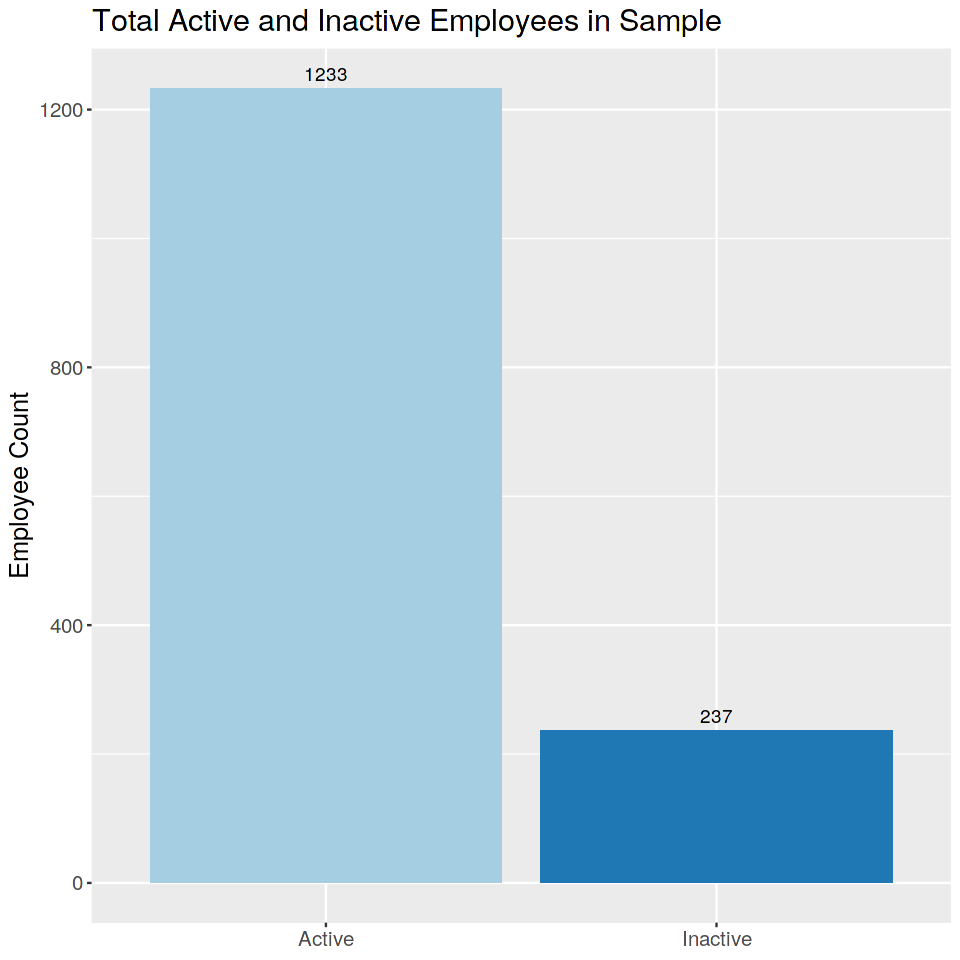

In [5]:
options(repr.plot.width = 8, repr.plot.height = 8)
employee_filter %>%
  group_by(Attrition) %>%
  ggplot(aes(factor(Attrition))) + geom_bar(aes(fill = Attrition)) + 
  scale_x_discrete(labels = c("Active", "Inactive")) + 
  theme(axis.title.x = element_blank()) + ylab("Employee Count") + 
  theme(legend.position = "none") + 
  geom_text(stat = "count", aes(label = ..count..), vjust = -.5) + 
  theme(text = element_text(size = 15)) + 
  ggtitle("Total Active and Inactive Employees in Sample") + 
  scale_fill_brewer(palette = "Paired")

Turnover rate by Department 

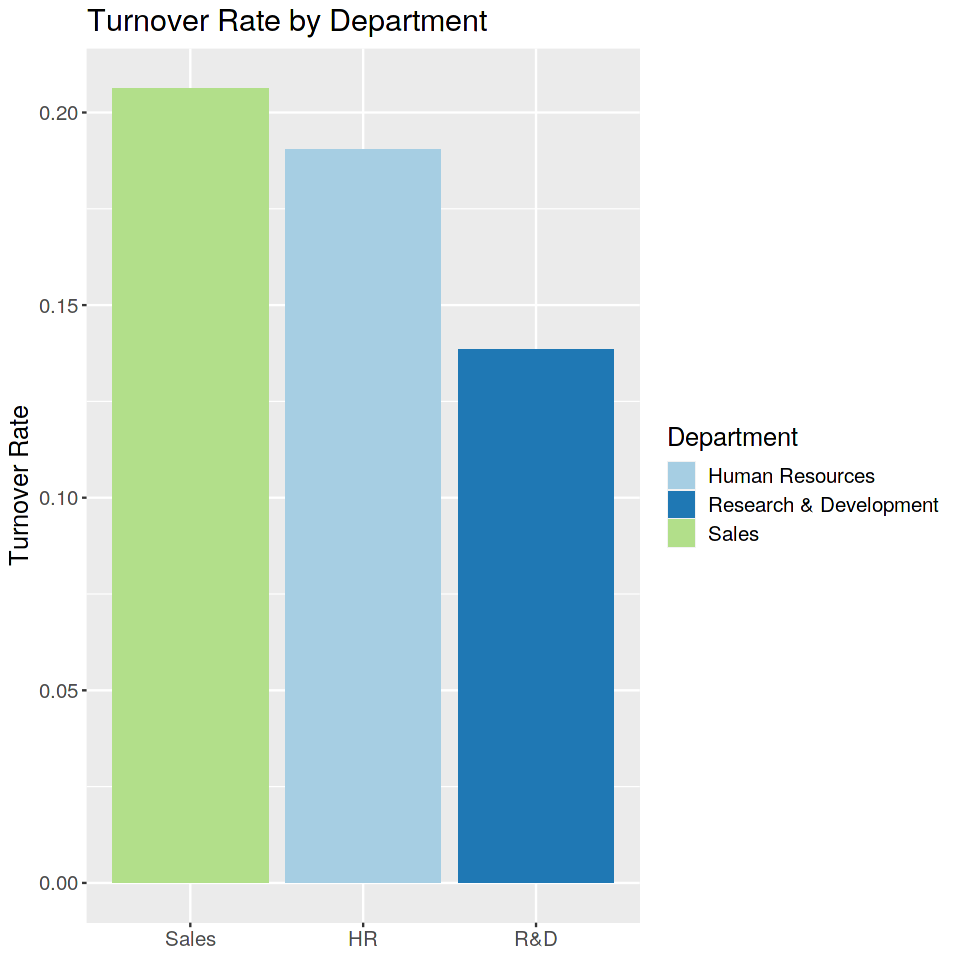

In [6]:
employee_filter %>%
  group_by(Department) %>%
  summarize(turnover_rate = mean(turnover), .groups = 'drop') %>%
  ggplot(aes(x = reorder(Department, -turnover_rate),y = turnover_rate)) + 
  geom_bar(stat = "identity", aes(fill = Department)) + 
  theme(axis.title.x = element_blank()) + ylab("Turnover Rate") + 
  scale_x_discrete(labels = c("Sales", "HR", "R&D")) + 
  ggtitle("Turnover Rate by Department")  + scale_fill_brewer(palette = "Paired") + 
  theme(text = element_text(size = 15)) 

Turnover rate by Gender 

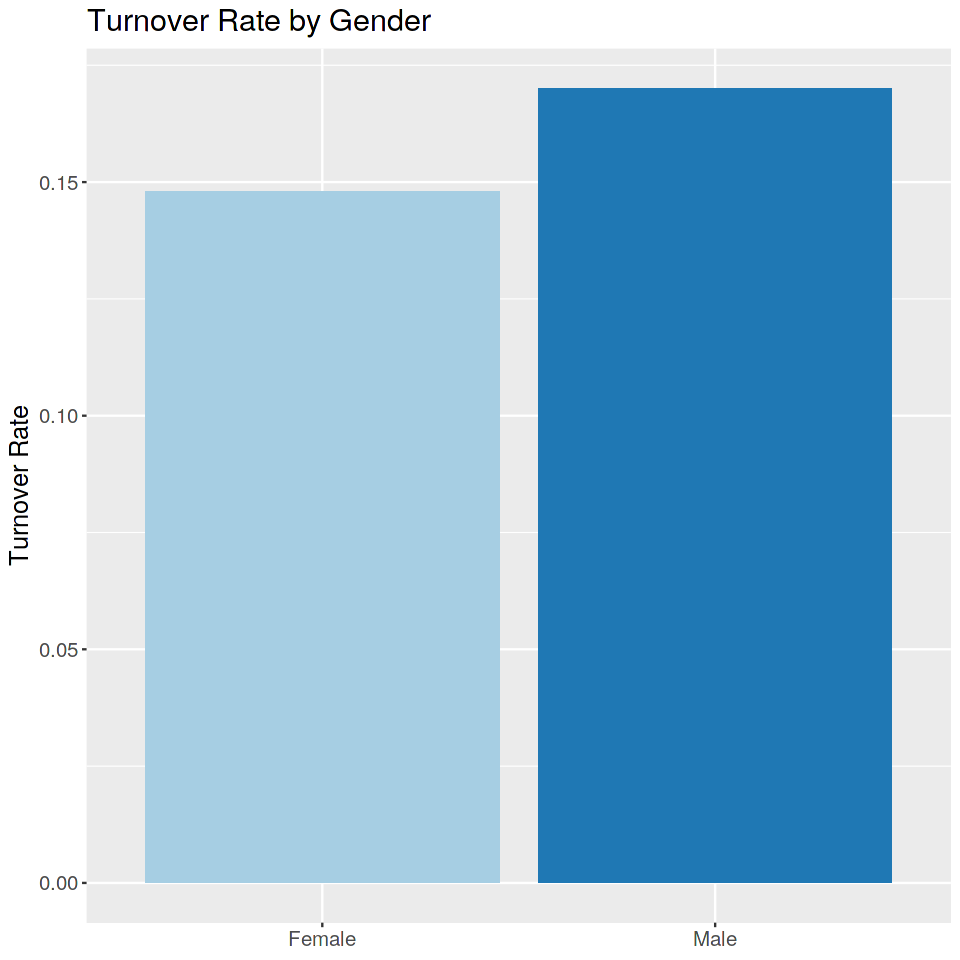

In [7]:
employee_filter %>%
  group_by(Gender) %>%
  summarize(turnover_rate = mean(turnover), .groups = 'drop') %>%
  ggplot(aes(Gender, turnover_rate))  + 
  geom_bar(stat = "identity", aes(fill = Gender)) + 
  theme(axis.title.x = element_blank()) + ylab("Turnover Rate") + 
  theme(legend.position = "none") + scale_fill_brewer(palette = "Paired") + 
  ggtitle("Turnover Rate by Gender") + 
  theme(text = element_text(size = 15)) 

Turnover rate by Job Level 

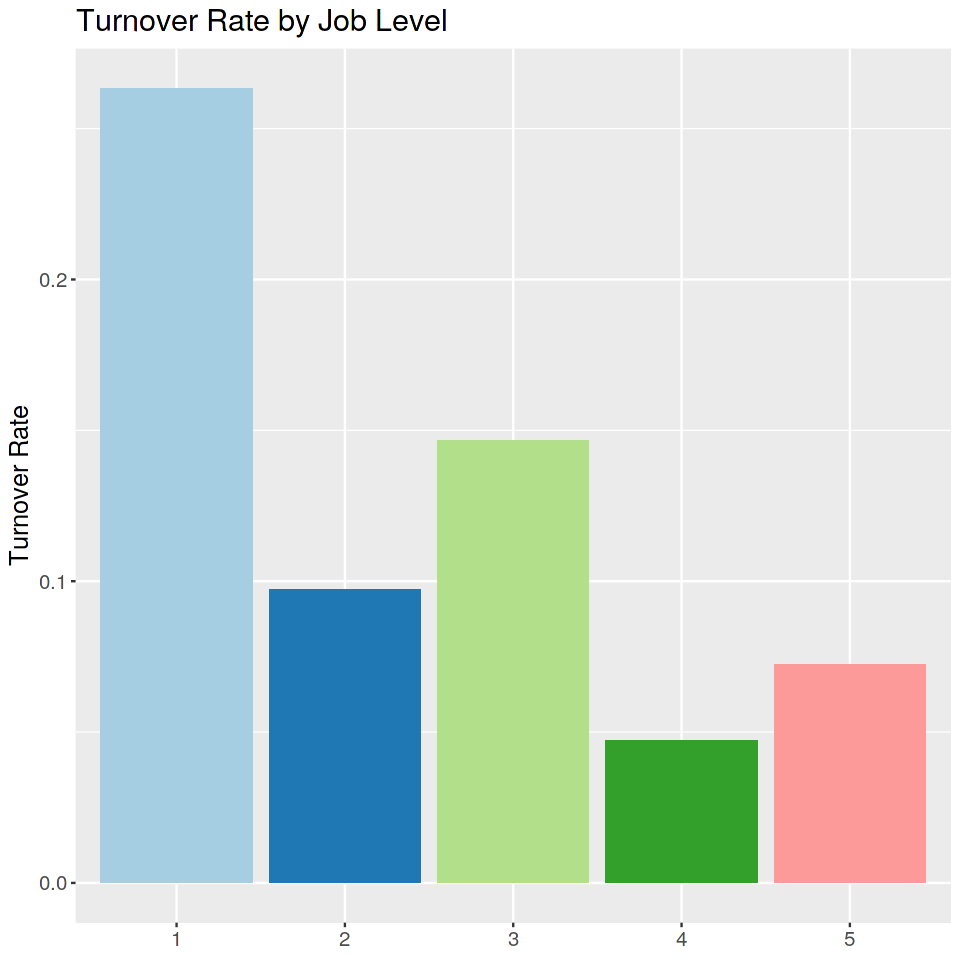

In [8]:
employee_filter %>%
  group_by(JobLevel) %>%
  summarize(turnover_rate = mean(turnover), .groups = 'drop') %>%
  ggplot(aes(JobLevel, turnover_rate))  + 
  geom_bar(stat = "identity", aes(fill = JobLevel)) + 
  theme(axis.title.x = element_blank()) + ylab("Turnover Rate") +
  theme(legend.position = "none") + scale_fill_brewer(palette = "Paired") + 
ggtitle("Turnover Rate by Job Level") + 
  theme(text = element_text(size = 15)) 

The following combined plots indicate the total employee counts by gender and job characteritics for the overall data set. We see that the number of employees by department are not equal, which is worth considering in the statistical analyses portions of this notebook as the models may need more data in the future from under-represented departments. 

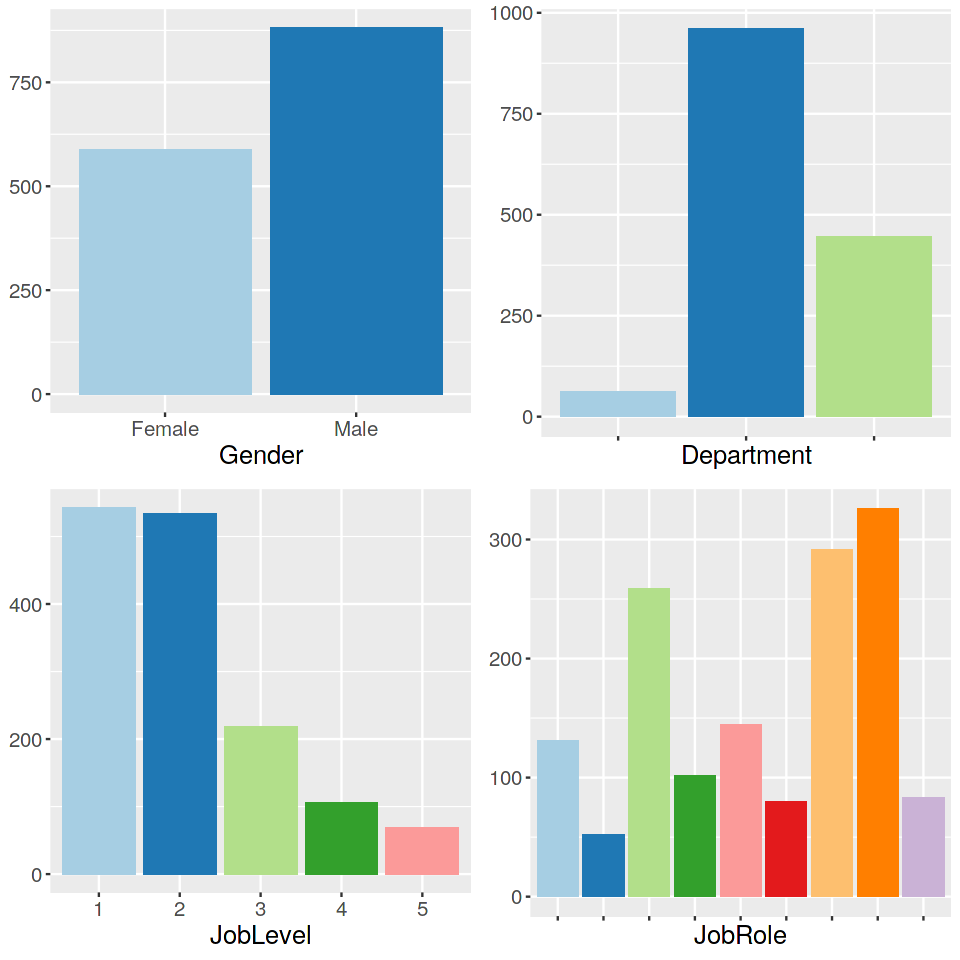

In [9]:
gender_count <- employee_filter %>%
  count(Gender) %>%
  ggplot(aes(x = Gender, y = n, fill = Gender)) + 
  geom_bar(stat = "identity") + theme(legend.position = "none") + 
  scale_fill_brewer(palette = "Paired")  + ylab("Count") +
  theme(axis.title.y = element_blank()) + 
  theme(text = element_text(size = 15))

department_count <- employee_filter %>%
  count(Department) %>%
  ggplot(aes(x = Department, y = n, fill = Department)) + 
  geom_bar(stat = "identity") + 
  theme(axis.text.x = element_blank(), legend.position = "none") +
  scale_fill_brewer(palette = "Paired") +
  theme(axis.title.y = element_blank()) + 
  theme(text = element_text(size = 15))

level_count <- employee_filter %>%
  count(JobLevel) %>%
  ggplot(aes(x = JobLevel, y = n, fill = JobLevel)) + 
  geom_bar(stat = "identity") + theme(legend.position = "none") + 
  scale_fill_brewer(palette = "Paired") +
  theme(axis.title.y = element_blank())+ 
  theme(text = element_text(size = 15))

role_count <- employee_filter %>%
  count(JobRole) %>%
  ggplot(aes(x = JobRole, y = n, fill = JobRole)) + 
  geom_bar(stat = "identity") +
  theme(axis.text.x = element_blank(), legend.position = "none") + 
  scale_fill_brewer(palette = "Paired") +
  theme(axis.title.y = element_blank()) + 
  theme(text = element_text(size = 15))

grid.arrange(gender_count, department_count, level_count, role_count) 


The next combined plot represents the same counts but now with just active employees. The counts of active employees only look similar to the combined plots above with the exception of Job Level 1, an entry-level position, which has relatively less active employees in proportion to the whole than in the total employee counts above. 

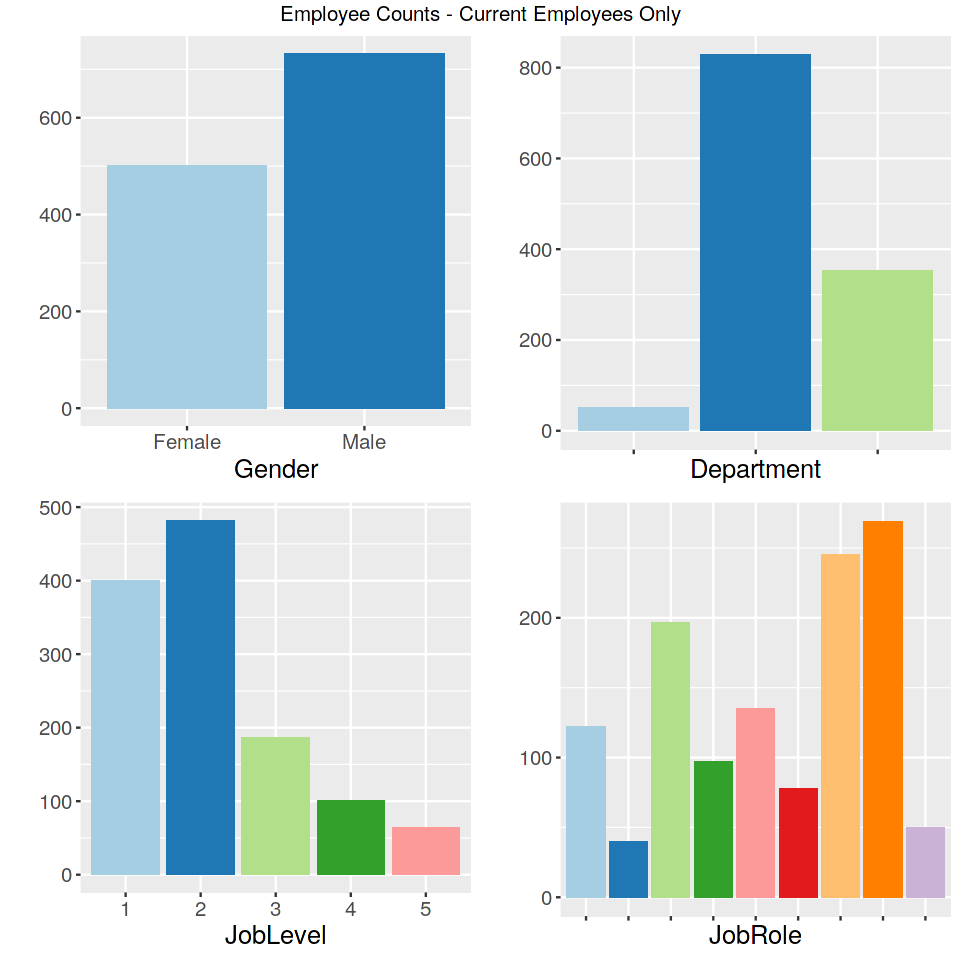

In [10]:
gender_current <- employee_filter %>%
  filter(Attrition == "No") %>%
  count(Gender) %>%
  ggplot(aes(x = Gender, y = n, fill = Gender)) + 
  geom_bar(stat = "identity") + theme(legend.position = "none") + 
  ylab("") + scale_fill_brewer(palette = "Paired") + 
  theme(text = element_text(size = 15))

department_current <- employee_filter %>%
  filter(Attrition == "No") %>%
  count(Department) %>%
  ggplot(aes(x = Department, y = n, fill = Department)) + 
  geom_bar(stat = "identity") + 
  theme(axis.text.x = element_blank(), legend.position = "none") + 
  ylab("") + scale_fill_brewer(palette = "Paired") + 
  theme(text = element_text(size = 15))

level_current <- employee_filter %>%
  filter(Attrition == "No") %>%
  count(JobLevel) %>%
  ggplot(aes(x = JobLevel, y = n, fill = JobLevel)) + 
  geom_bar(stat = "identity") + theme(legend.position = "none") + 
  ylab("") + scale_fill_brewer(palette = "Paired") + 
  theme(text = element_text(size = 15))

role_current <- employee_filter %>%
  filter(Attrition == "No") %>%
  count(JobRole) %>%
  ggplot(aes(x = JobRole, y = n, fill = JobRole)) + 
  geom_bar(stat = "identity") +
  theme(axis.text.x = element_blank(), legend.position = "none") + 
  ylab("") + scale_fill_brewer(palette = "Paired") + 
  theme(text = element_text(size = 15))

grid.arrange(gender_current, department_current, level_current, role_current, 
             top = "Employee Counts - Current Employees Only")


**III) Feature Engineering **


In this section of the notebook, I create a new version of the dataset called 'employee'. I continually re-call 'employee' as I add new metrics through feature engineering. Those new metrics include the following: 

In [11]:
# High Potentials 
employee <- employee_filter %>%
  mutate(hipo = ifelse(PerformanceRating == "4", 1, 0)) 

Disengaged Employees 

In [12]:

employee <- employee %>%
  mutate(disengaged = ifelse(JobSatisfaction == "1", 1, 0)) 

employee %>%
  group_by(disengaged) %>%
count(disengaged)

disengaged,n
<dbl>,<int>
0,1181
1,289


Compensation Ratio - Comparison to Median Pay 

Median compensation ratio (compa ratio) is calculated as the proportion of an employee's overall monthly income to the median compensation of peers in their job level. The density distribution below shows the distribution of monthly income in the company by job level. 

JobLevel,median_comp
<fct>,<dbl>
2,5340
1,2670
3,9980
4,16154
5,19232


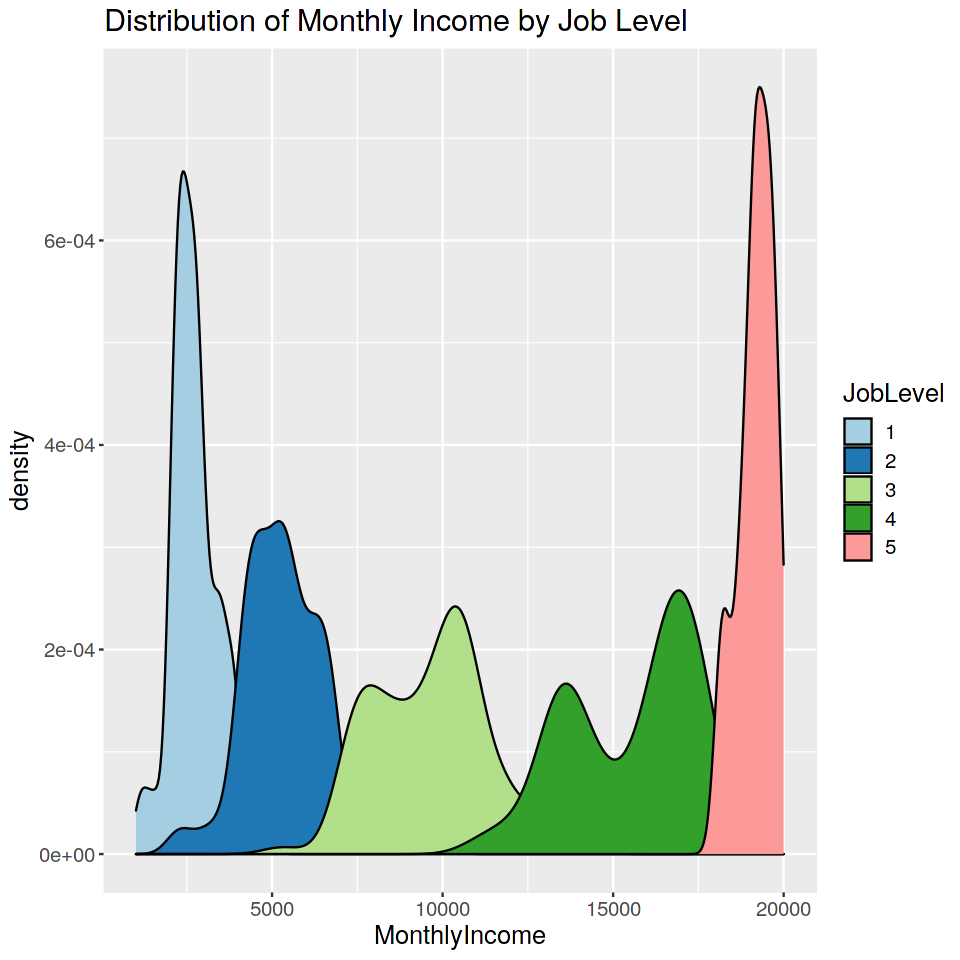

In [13]:
employee <- employee %>%
  group_by(JobLevel) %>% 
  mutate(median_comp = median(MonthlyIncome), 
         compa_ratio = (MonthlyIncome/ median_comp))

employee %>%
  distinct(JobLevel, median_comp)

employee <- employee %>%
  mutate(compa_level = ifelse(compa_ratio > 1, "Above", "Below")) 

employee %>%
  ggplot() + geom_density(aes(x = MonthlyIncome, fill = JobLevel)) + theme(text = element_text(size = 15)) + 
ggtitle("Distribution of Monthly Income by Job Level") + 
scale_fill_brewer(palette = "Paired") 


Annualized Salary

Annualized salary is estimated by twelve times an employee's monthly income. The table below incidates the average annual salary at this company based on job level. 

In [14]:
employee <- employee %>%
  mutate(AnnualSalary = MonthlyIncome * 12)

employee %>%
  group_by(JobLevel) %>%
  summarize(avg_salary = mean(AnnualSalary), .groups = 'drop') 

JobLevel,avg_salary
<fct>,<dbl>
1,33442.98
2,66027.33
3,117807.03
4,186045.40
5,230301.91


Job Hop Index 

Job Hop Index is calcuated as the ratio of total working years to number of previous companies worked, providing a numerical estimate for the average number of years working at each company in one's career. The density curve shows the distribution of job hopping in this company's workforce. 

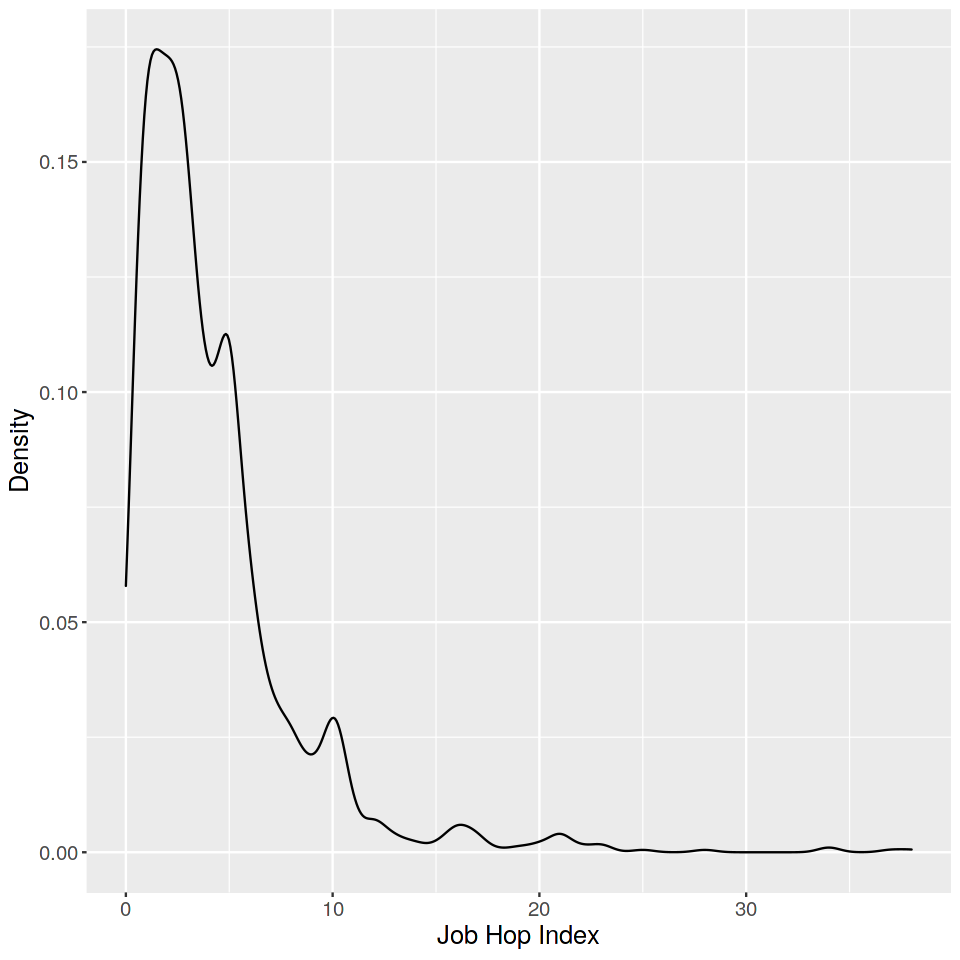

In [15]:
employee <- employee %>%
  mutate(job_hop = (TotalWorkingYears/ (NumCompaniesWorked + 1))) 

employee %>%
  ggplot() + geom_density(aes(x = job_hop)) + xlab("Job Hop Index") + ylab("Density") + theme(text = element_text(size = 15))

**IV) Significance Testing **


In this section, I run statistical analyses on the data to identify causes of employee attrition in our data sample. The first significance test finds that employees who left the company were statistically more disengaged than current employees at the company - an outcome we'd expect. 


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-0.09762132,0.1808597,0.278481,-3.131775,0.001905411,306.2031,-0.1589583,-0.03628436,Welch Two Sample t-test,two.sided


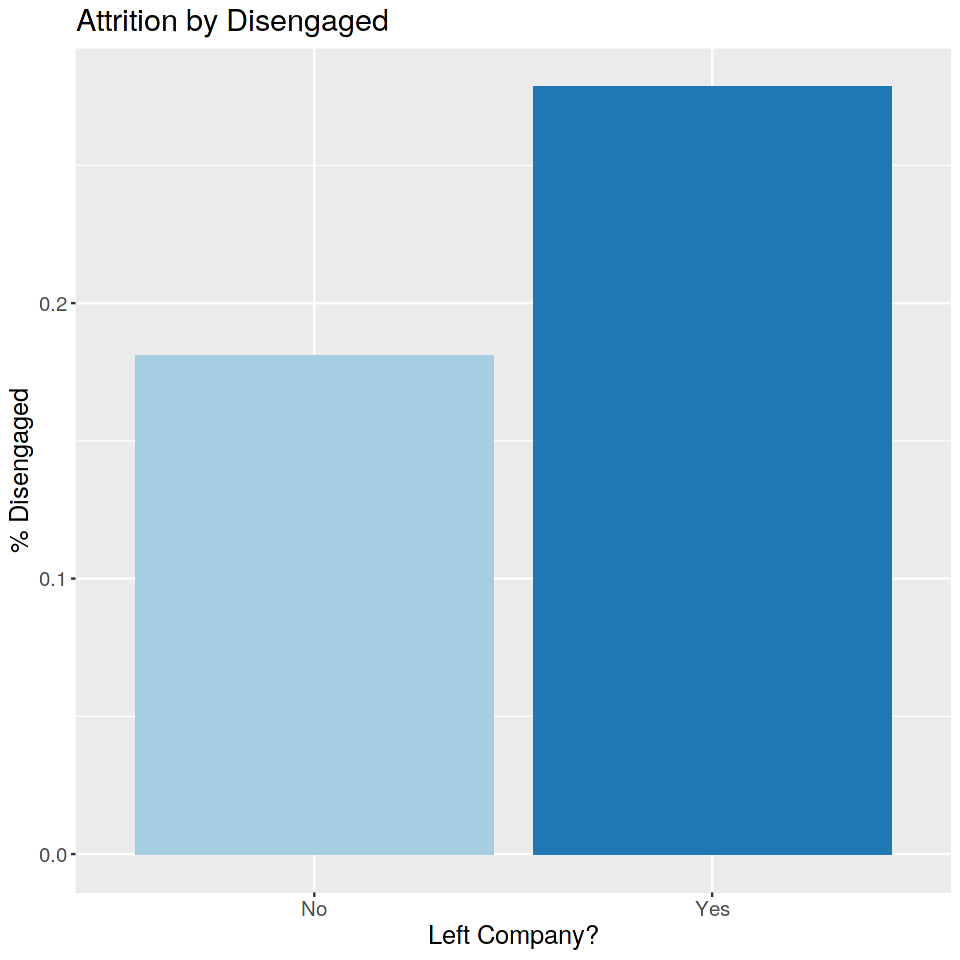

In [16]:
employee %>%
  group_by(Attrition) %>%
  summarize(avg_disengagement = mean(disengaged), .groups = 'drop') %>%
  ggplot(aes(Attrition, avg_disengagement)) + geom_col(aes(fill = Attrition)) + 
  xlab("Left Company?") + ylab("% Disengaged") + 
  theme(legend.position = "none") + scale_fill_brewer(palette = "Paired") + ggtitle("Attrition by Disengaged") + 
  theme(text = element_text(size = 15))

t.test(disengaged ~ Attrition, data = employee) %>%
  tidy()


The next significance test explores whether employees who are disenaged are paid less employees. We find that there is no difference in pay between engaged and disengaged employees. The boxplot below shows near similar median pay and interquartile ranges for pay across enagaged and disengaged groups.  

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.429056e+00,1.119698e-01,-12.7628664,2.642935e-37
MonthlyIncome,3.274426e-06,1.385678e-05,0.2363049,8.131961e-01


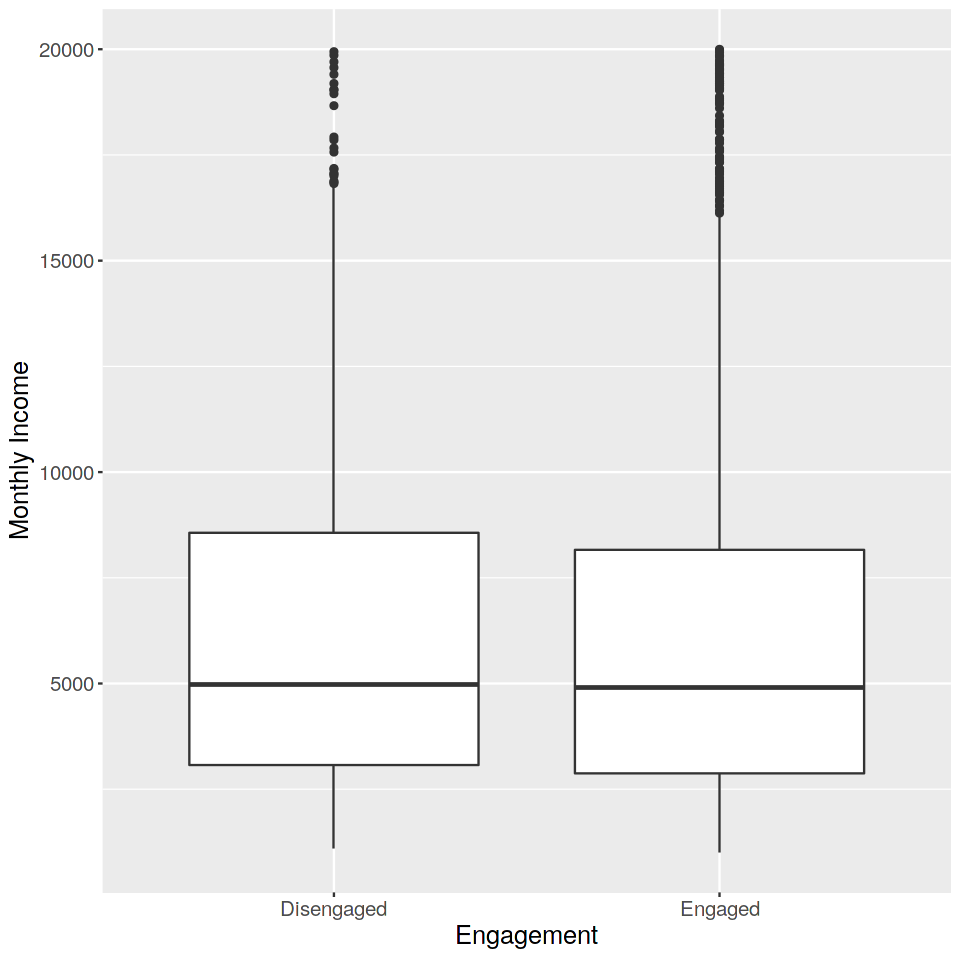

In [17]:
employee %>%
  mutate(dis_label = ifelse(disengaged == "1", "Disengaged", "Engaged")) %>%
  ggplot(aes(dis_label, MonthlyIncome)) + geom_boxplot(aes(group = dis_label)) + 
  theme(text = element_text(size = 15)) + xlab("Engagement") + ylab("Monthly Income")


glm(disengaged ~ MonthlyIncome, family = "binomial", data =employee) %>%
  tidy()

Next, I explore whether turnover rates were statistically higher for speicfic job levels. The analysis finds that turnover rates are different by job level. 

JobLevel,avg_turnover
<fct>,<dbl>
1,0.26335175
3,0.14678899
2,0.09737828
5,0.07246377
4,0.04716981


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.0286199,0.09743206,-10.557304,4.699658e-26
JobLevel2,-1.1980805,0.17549491,-6.826867,8.678892e-12
JobLevel3,-0.7313909,0.21475416,-3.405712,6.599173e-04
JobLevel4,-1.9770627,0.46835848,-4.221260,2.429411e-05
JobLevel5,-1.5208253,0.47446548,-3.205344,1.349010e-03


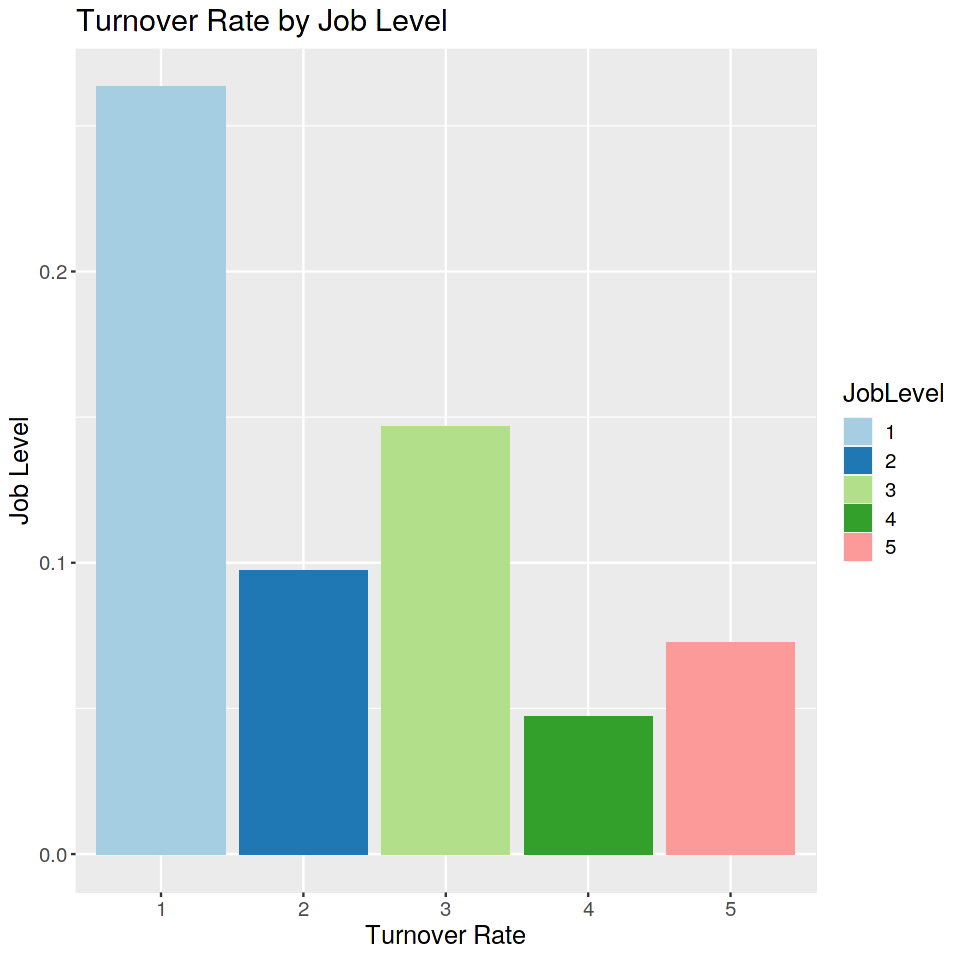

In [18]:
employee %>%
  group_by(JobLevel) %>%
  summarize(avg_turnover = mean(turnover), .groups = 'drop') %>%
  arrange(desc(avg_turnover)) 

employee %>%
  group_by(JobLevel) %>%
  summarize(avg_turnover = mean(turnover), .groups = 'drop') %>%
  ggplot(aes(JobLevel, avg_turnover, fill = JobLevel)) + 
  geom_bar(stat = "identity") + ylab("Job Level") + xlab("Turnover Rate") + 
  ggtitle("Turnover Rate by Job Level") + scale_fill_brewer(palette = "Paired") + 
  theme(text = element_text(size = 15)) 

glm(turnover ~ JobLevel, family = "binomial", data = employee) %>%
  tidy()

Earlier, disengagement was correlated with leaving the company. Does Job Level predict disengagement at this company? What about disenagement within departments and roles at the company? 


In [19]:
glm(disengaged ~ Department, family = "binomial", data = employee) %>%
  tidy()
glm(disengaged ~ JobRole, family = "binomial", data = employee) %>%
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.5533484,0.3318733,-4.6805472,2.861102e-06
DepartmentResearch & Development,0.1657528,0.3415385,0.4853123,6.274549e-01
DepartmentSales,0.1215917,0.3529101,0.3445402,7.304401e-01


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.39586381,0.2190555,-6.37219153,1.863460e-10
JobRoleHuman Resources,-0.03922071,0.4144814,-0.09462599,9.246119e-01
JobRoleLaboratory Technician,0.10800952,0.2660236,0.40601482,6.847317e-01
JobRoleManager,0.04593710,0.3285575,0.13981449,8.888066e-01
JobRoleManufacturing Director,-0.12516314,0.3079776,-0.40640335,6.844463e-01
JobRoleResearch Director,-0.07047326,0.3606059,-0.19543014,8.450562e-01
JobRoleResearch Scientist,-0.08742281,0.2659051,-0.32877449,7.423261e-01
JobRoleSales Executive,0.08089423,0.2576220,0.31400354,7.535184e-01
JobRoleSales Representative,-0.38190942,0.3813176,-1.00155190,3.165601e-01


Department and job role are not statistically correlated with disengagement.


But are either of these predictors statistically correlated with the observed attrition at the company? 

In [20]:
glm(turnover ~ Department, family = "binomial", data = employee) %>%
  tidy()
glm(turnover ~ JobRole, family = "binomial", data = employee) %>%
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.44691898,0.3208444,-4.5097213,6.491286e-06
DepartmentResearch & Development,-0.38174504,0.3341671,-1.1423776,2.532971e-01
DepartmentSales,0.09941065,0.3415195,0.2910834,7.709876e-01


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2.606796467,0.3454097,-7.546970389,4.454998e-14
JobRoleHuman Resources,1.402823663,0.4771176,2.940205479,3.279947e-03
JobRoleLaboratory Technician,1.450727124,0.3748506,3.870147055,1.087697e-04
JobRoleManager,-0.358476599,0.5741229,-0.624389997,5.323715e-01
JobRoleManufacturing Director,0.004106782,0.4761462,0.008625043,9.931183e-01
JobRoleResearch Director,-1.056765179,0.7950582,-1.329167046,1.837929e-01
JobRoleResearch Scientist,0.955685859,0.3803499,2.512649040,1.198285e-02
JobRoleSales Executive,1.055136356,0.3749255,2.814255710,4.889032e-03
JobRoleSales Representative,2.191281023,0.4118384,5.320730305,1.033515e-07


Here we see that department shows no statistical effect on attrition. However, job level does seem to.


Does one's proclivity to job hopping have an effect on attrition outcome? 

In [21]:
glm(turnover ~ job_hop, family = "binomial", data = employee) %>%
 tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.0184435,0.11610731,-8.771571,1.761906e-18
job_hop,-0.1822377,0.03096985,-5.884360,3.995967e-09


**V) Model Development: Multiple Logistic Regression **


Calculate Information Value: 

In [22]:
IV <- create_infotables(data = employee, y = "turnover") 
IV$Summary

,Variable,IV
,<chr>,<dbl>
15,JobRole,4.909971e-01
39,job_hop,4.819959e-01
18,MonthlyIncome,4.250153e-01
38,AnnualSalary,4.250153e-01
21,OverTime,4.001828e-01
14,JobLevel,3.841516e-01
35,median_comp,3.796698e-01
26,TotalWorkingYears,3.775447e-01
29,YearsAtCompany,3.366758e-01



Split employee data set into training and testing data set. Check to ensure proportions of active and inactive employees are similar between data sets. It's also a good idea to check to that job level proportions are similar in both data sets. 

In [23]:
set.seed(401) 

index_training <- createDataPartition(employee$turnover, p = 0.5, list = FALSE) 
training_set <- employee[index_training, ]
testing_set <- employee[-index_training, ]

# check proportions in training and testing data sets 

training_set %>%
  count(Attrition) %>%
  mutate(prop = n/sum(n)) 

testing_set %>%
  count(Attrition) %>%
  mutate(prop = n/sum(n))

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


JobLevel,Attrition,n,prop
<fct>,<chr>,<int>,<dbl>
1,No,207,0.74460432
1,Yes,71,0.25539568
2,No,253,0.93014706
2,Yes,19,0.06985294
3,No,82,0.85416667
3,Yes,14,0.14583333
4,No,53,0.98148148
4,Yes,1,0.01851852
5,No,32,0.91428571


JobLevel,Attrition,n,prop
<fct>,<chr>,<int>,<dbl>
1,No,193,0.72830189
1,Yes,72,0.27169811
2,No,229,0.87404580
2,Yes,33,0.12595420
3,No,104,0.85245902
3,Yes,18,0.14754098
4,No,48,0.92307692
4,Yes,4,0.07692308
5,No,32,0.94117647


Assessment of multicollinearity - test Variance Inflation Factor (VIF)

In [24]:
# generate multiple logistic regression model from all independent variables


training_set_filter <- training_set %>%
  select(-c(EmployeeNumber, BusinessTravel, Attrition, hipo))


multi_log <- glm(turnover ~ ., family = "binomial", data = training_set_filter,  maxit = 100)  

At this point, checking the model's VIF throws the follwowing error: aliased coefficients in the model.  
Run summary() on the model to identify if some of the columns are perfectly collinear with other variables. Summary finds median compensation and annual salary as trouble variables here so I remove and check VIF once again. 

In [25]:
summary(multi_log)



Call:
glm(formula = turnover ~ ., family = "binomial", data = training_set_filter, 
    maxit = 100)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.89320  -0.40095  -0.18477  -0.04302   3.15487  

Coefficients: (2 not defined because of singularities)
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -5.813e+00  8.422e+02  -0.007 0.994493    
Age                              -2.053e-02  2.188e-02  -0.938 0.348097    
DailyRate                        -4.096e-04  3.524e-04  -1.162 0.245107    
DepartmentResearch & Development  1.301e+01  8.422e+02   0.015 0.987677    
DepartmentSales                   1.384e+01  8.422e+02   0.016 0.986892    
DistanceFromHome                  3.838e-02  1.747e-02   2.197 0.028043 *  
Education2                       -2.062e-01  5.552e-01  -0.371 0.710298    
Education3                        5.362e-01  4.564e-01   1.175 0.239967    
Education4                        

In [26]:
training_set_filter <- training_set_filter %>%
  select(-c(median_comp, AnnualSalary)) 
multi_log <- glm(turnover ~ ., family = "binomial", data = training_set_filter,  maxit = 100)  
vif(multi_log)

,GVIF,Df,GVIF^(1/(2*Df))
Age,2.269994e+00,1,1.506650
DailyRate,1.186041e+00,1,1.089055
Department,8.025544e+07,2,94.649564
DistanceFromHome,1.159255e+00,1,1.076687
Education,2.056105e+00,4,1.094286
EducationField,5.931670e+00,5,1.194862
EnvironmentSatisfaction,1.250930e+00,1,1.118450
Gender,1.157181e+00,1,1.075724
HourlyRate,1.179941e+00,1,1.086251
JobInvolvement,1.088150e+00,1,1.043144


Repeat steps to remove variable with highest VIF one at a time until all VIF scores are less than 5. 

In [27]:
model_2 <- glm(turnover ~ . -JobRole, family = "binomial", data = training_set_filter, maxit = 100)
vif(model_2)
model_3 <- glm(turnover ~ . -JobRole - JobLevel, family = "binomial", data = training_set_filter, maxit = 100) 
vif(model_3)

model_final <- glm(turnover ~ . -JobRole - JobLevel -YearsAtCompany, family = "binomial", data = training_set_filter, maxit = 100) 
vif(model_final)

,GVIF,Df,GVIF^(1/(2*Df))
Age,2.232791,1,1.494253
DailyRate,1.157888,1,1.076052
Department,4.642600,2,1.467879
DistanceFromHome,1.119489,1,1.058059
Education,1.656665,4,1.065134
EducationField,5.253820,5,1.180450
EnvironmentSatisfaction,1.165163,1,1.079427
Gender,1.107098,1,1.052187
HourlyRate,1.116065,1,1.056440
JobInvolvement,1.065617,1,1.032287


,GVIF,Df,GVIF^(1/(2*Df))
Age,2.059964,1,1.435257
DailyRate,1.137344,1,1.066464
Department,4.207811,2,1.432234
DistanceFromHome,1.094412,1,1.046141
Education,1.536033,4,1.055116
EducationField,5.139691,5,1.177860
EnvironmentSatisfaction,1.149599,1,1.072193
Gender,1.101016,1,1.049293
HourlyRate,1.086434,1,1.042321
JobInvolvement,1.050024,1,1.024707


,GVIF,Df,GVIF^(1/(2*Df))
Age,2.026366,1,1.423505
DailyRate,1.123488,1,1.059947
Department,4.189372,2,1.430663
DistanceFromHome,1.092967,1,1.045450
Education,1.500195,4,1.052007
EducationField,4.925845,5,1.172865
EnvironmentSatisfaction,1.146481,1,1.070738
Gender,1.108055,1,1.052642
HourlyRate,1.079324,1,1.038905
JobInvolvement,1.047668,1,1.023557


High VIF scores have been successfully removed. 

Generate predictions on training data set and visualize prediciton distribution: 

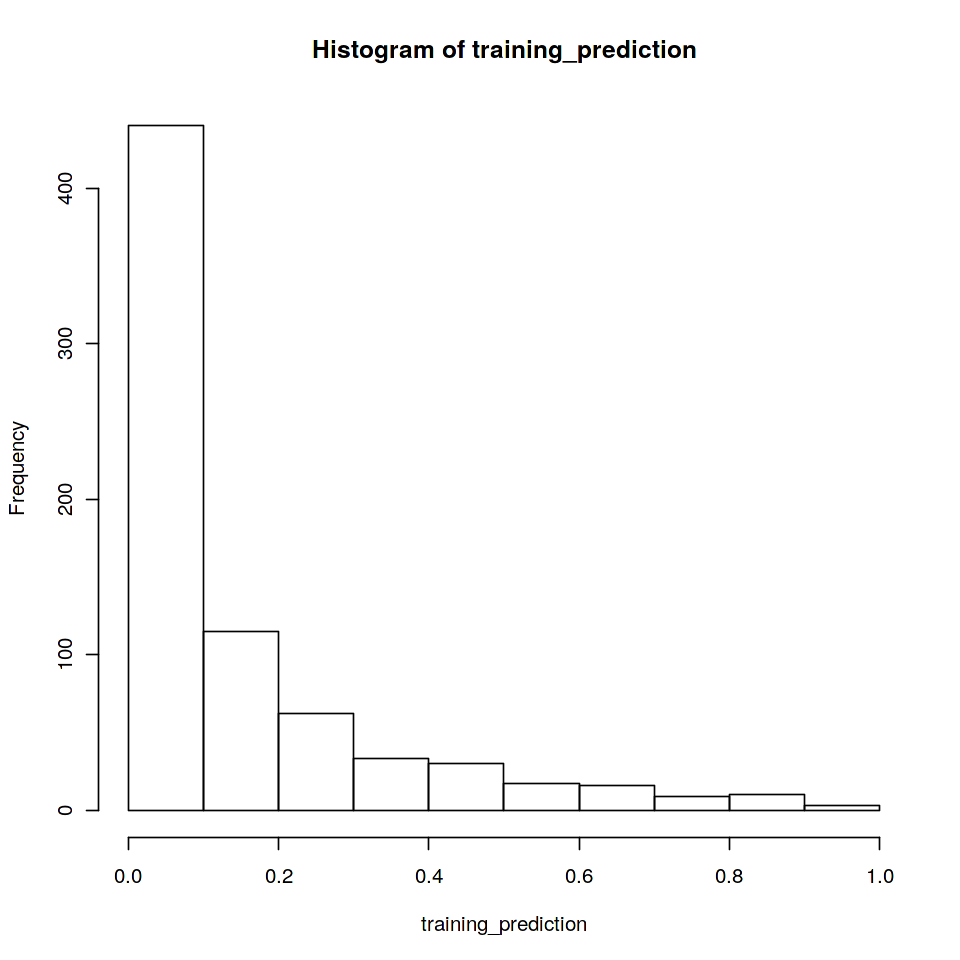

In [28]:
training_prediction <- predict(model_final, 
                               newdata = training_set_filter, type = "response") 
hist(training_prediction)

Now the model predicts outcomes on the out-of-sample data that was stored in the test set: 

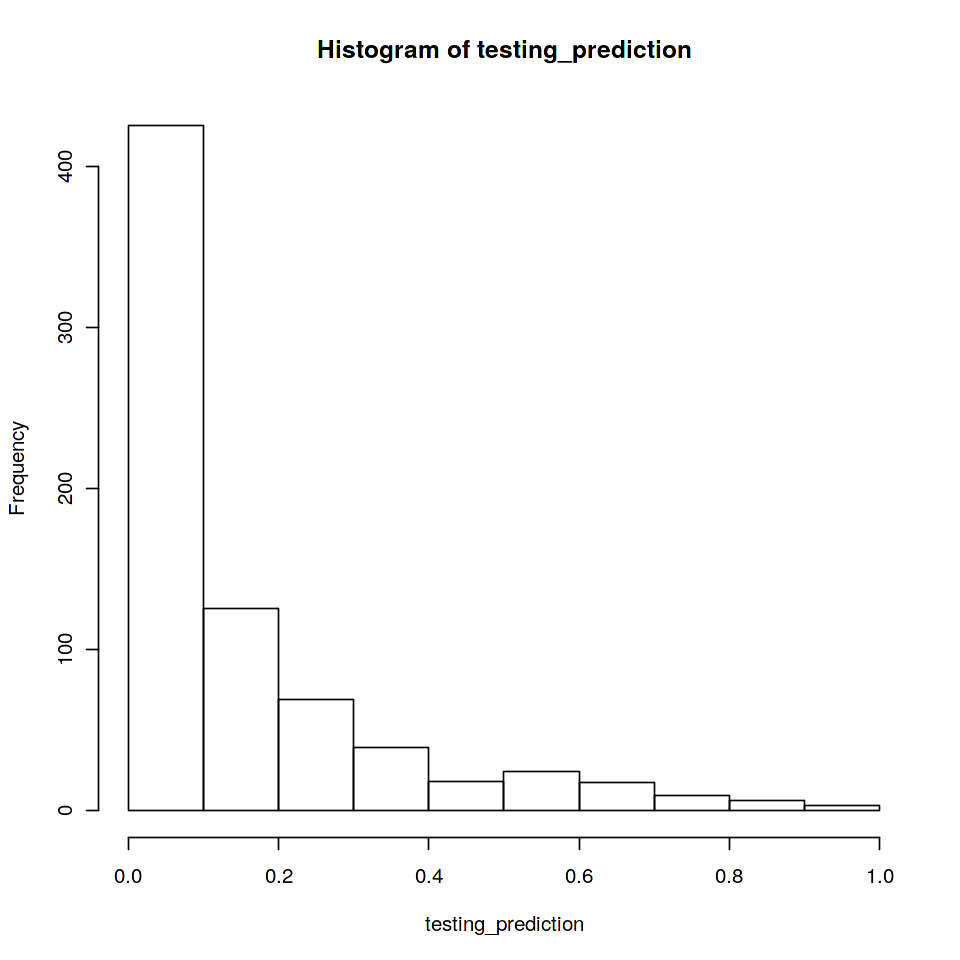

In [29]:
testing_prediction <- predict(model_final, 
                              newdata = testing_set, type = "response")
hist(testing_prediction)


Turn probabilities into binary responses with a 0.5 cutoff point and generate a confusion matrix to observe model's accuracy. 

In [30]:
# classify predictions with cutoff score 

predicition_cutoff <- ifelse(testing_prediction > 0.5, 1, 0)
table(predicition_cutoff, testing_set$turnover)


# generate confusion matrix 

conf_matrix <- confusionMatrix(table(testing_set$turnover, 
                                          predicition_cutoff))
conf_matrix

                  
predicition_cutoff   0   1
                 0 582  94
                 1  24  35

Confusion Matrix and Statistics

   predicition_cutoff
      0   1
  0 582  24
  1  94  35
                                          
               Accuracy : 0.8395          
                 95% CI : (0.8109, 0.8653)
    No Information Rate : 0.9197          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2946          
                                          
 Mcnemar's Test P-Value : 2.126e-10       
                                          
            Sensitivity : 0.8609          
            Specificity : 0.5932          
         Pos Pred Value : 0.9604          
         Neg Pred Value : 0.2713          
             Prevalence : 0.9197          
         Detection Rate : 0.7918          
   Detection Prevalence : 0.8245          
      Balanced Accuracy : 0.7271          
                                          
       'Positive' Class : 0               
                                          

In [31]:
summary(model_final)


Call:
glm(formula = turnover ~ . - JobRole - JobLevel - YearsAtCompany, 
    family = "binomial", data = training_set_filter, maxit = 100)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7197  -0.4789  -0.2636  -0.1077   3.1917  

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       5.061e+00  2.216e+00   2.284  0.02237 *  
Age                              -1.952e-02  2.010e-02  -0.971  0.33158    
DailyRate                        -3.426e-04  3.217e-04  -1.065  0.28687    
DepartmentResearch & Development -2.094e-01  8.599e-01  -0.244  0.80759    
DepartmentSales                   6.140e-01  8.799e-01   0.698  0.48527    
DistanceFromHome                  2.855e-02  1.552e-02   1.839  0.06596 .  
Education2                       -1.505e-01  5.179e-01  -0.291  0.77128    
Education3                        6.165e-01  4.286e-01   1.438  0.15038    
Education4                        5.835e-01  4.

** VI) k-Nearest Neighbor Classifier **

In [32]:
em <- employee %>%
  ungroup(JobLevel) %>%
  select(Attrition, DailyRate, EnvironmentSatisfaction, PerformanceRating, 
         RelationshipSatisfaction)


Normalize the numerical data: 

In [33]:
ran <- runif(nrow(em)) 

em <- em [order(ran), ]

normalize <- function(x) { 
  return ((x - min(x)) / (max(x) - min(x))) }

em_norm <- as.data.frame(lapply(em[2:5], normalize)) 
str(em_norm)


'data.frame':	1470 obs. of  4 variables:
 $ DailyRate               : num  0.1546 0.0823 0.7316 0.7652 0.3429 ...
 $ EnvironmentSatisfaction : num  1 0 0.333 1 0.667 ...
 $ PerformanceRating       : num  0 1 1 0 0 0 0 0 0 0 ...
 $ RelationshipSatisfaction: num  0 0 0.667 0.667 1 ...


Calculate and execute the data splits

In [34]:
1470 * 0.7
1470- 1029
sqrt(1470)
em_train <- em_norm[1:1029, ]
em_test <- em_norm[1030:1470, ]
em_train_target <- em$Attrition[1:1029] 
em_test_target <- em$Attrition[1030:1470] 

[1] 1029

[1] 441

[1] 38.34058

Run kNN and generate confusion matrix: 

In [35]:
library(class) 
library(caret) 
em_test_pred <- knn(train = em_train, test = em_test, cl = em_train_target, 
                    k = 38)


tab <- table(em_test_pred, em_test_target)
tab

            em_test_target
em_test_pred  No Yes
         No  371  70
         Yes   0   0

kNN showing 84% accuracy although it incorrectly classified all of those instances in which an employee left in the target sample. 

**VII) Risk Assessment****

Below, I filter by current employees only. I'll then apply the model to the filtered data set to generate indiviudal turnover probabilities. 

In [36]:
employee_current <- employee %>%
  filter(Attrition == "No")

employee_current$churn_risk <- predict(model_final, newdata = employee_current, 
                          type = "response") 

# check random employees' churn risk 
employee_current$churn_risk[c(100, 1003)]

100       1003 
0.04335952 0.46247777

Generate risk buckets for an estimation on the opportunity size for workforce retention efforts: 

In [37]:
employee_risk <- employee_current %>%
  mutate(risk_level = cut(churn_risk, breaks = c(0, 0.2, 0.3, 0.5, 1), 
                          labels = c("no-risk", "low-risk",
                                     "medium-risk", "high-risk")))
employee_risk %>%
  group_by(risk_level) %>%
  count(risk_level) 

risk_level,n
<fct>,<int>
no-risk,1029
low-risk,94
medium-risk,73
high-risk,37


Before moving on to proposed intervention efforts, I wanted to generate and validate another logistic regression model. I pare back the number of predicting variables in the second model to see if my model accuracy can be improved. 


[1] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE
[13]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE
[25]  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE
[37]  TRUE  TRUE  TRUE  TRUE

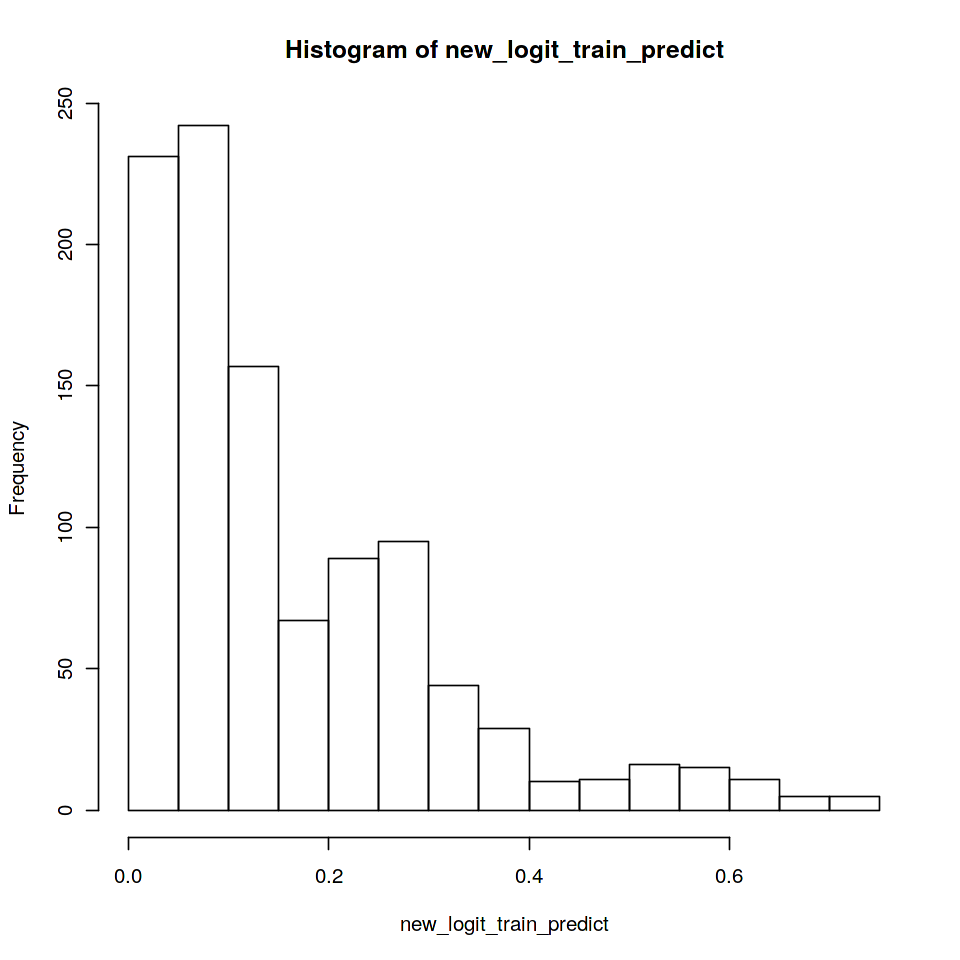

   
    FALSE TRUE
  0   841   19
  1   134   33

[1] 0.8510224

                               
new_logit_prediction_categories   0   1
                              0 366  56
                              1   7  14

Confusion Matrix and Statistics

                               
new_logit_prediction_categories   0   1
                              0 366  56
                              1   7  14
                                         
               Accuracy : 0.8578         
                 95% CI : (0.8217, 0.889)
    No Information Rate : 0.842          
    P-Value [Acc > NIR] : 0.1997         
                                         
                  Kappa : 0.2532         
                                         
 Mcnemar's Test P-Value : 1.472e-09      
                                         
            Sensitivity : 0.9812         
            Specificity : 0.2000         
         Pos Pred Value : 0.8673         
         Neg Pred Value : 0.6667         
             Prevalence : 0.8420         
         Detection Rate : 0.8262         
   Detection Prevalence : 0.9526         
      Balanced Accuracy : 0.5906         
                                         
       'Positive'

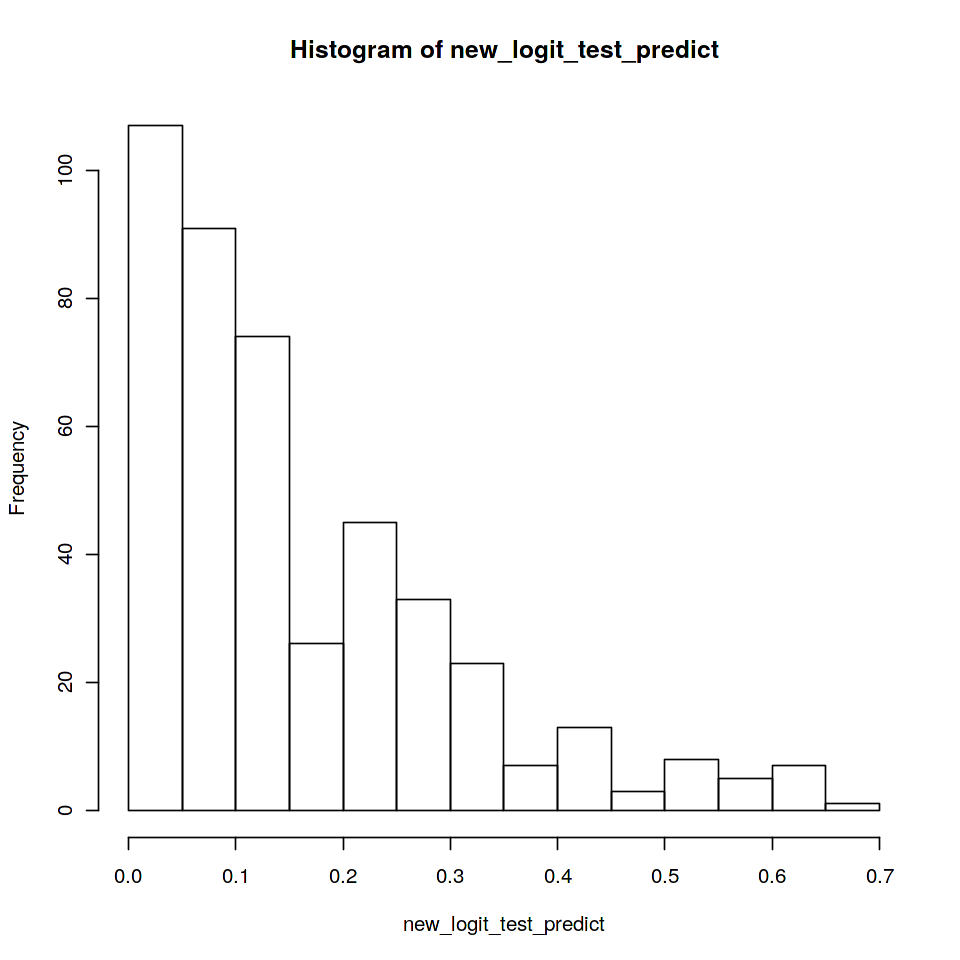

In [38]:
# split data 

library(caTools)
split <- sample.split(as.data.frame(employee), SplitRatio = 0.7) 
split
train <- subset(as.data.frame(employee), split == "TRUE")
test <- subset(as.data.frame(employee), split == "FALSE") 



new_logit <- glm(turnover ~ JobRole + MonthlyIncome + OverTime + JobLevel + 
                   TotalWorkingYears + YearsAtCompany + Age, 
                 family = "binomial", data = train) 
new_logit_train_predict <- predict(new_logit, 
                               newdata = train, type = "response") 
hist(new_logit_train_predict)


# run new model through test data set; check for 
# similarity in prediction distribution

new_logit_test_predict <- predict(new_logit, 
                                   newdata = test, type = "response") 
hist(new_logit_test_predict)



# confusion matrix 

new_logit_conf_matrix <- table(train$turnover, new_logit_train_predict > 0.5) 
new_logit_conf_matrix

(new_logit_conf_matrix[[1,1]] + new_logit_conf_matrix[[2,2]]) / sum(new_logit_conf_matrix)
new_logit_prediction_categories <- ifelse(new_logit_test_predict > 0.5, 1, 0)

# Construct a confusion matrix
new_logit_conf_matrix <- table(new_logit_prediction_categories, test$turnover)
new_logit_conf_matrix
confusionMatrix(new_logit_conf_matrix)

**VIII) Retention Strategy **